In [48]:
'''
import tensorflow as tf
import tensorflow_datasets as tfds

# Load COCO dataset or any other object detection dataset
dataset, info = tfds.load('coco', split='train', with_info=True)
'''

"\nimport tensorflow as tf\nimport tensorflow_datasets as tfds\n\n# Load COCO dataset or any other object detection dataset\ndataset, info = tfds.load('coco', split='train', with_info=True)\n"

In [73]:
import tensorflow_datasets as tfds

# Load the Pascal VOC dataset
dataset, info = tfds.load("voc/2007", split="train", with_info=True)

# Load and Prepare Dataset
#### We will use a simple dataset (like MNIST or COCO) for demonstration. The dataset will be used to train both the GAN and the object detection model.

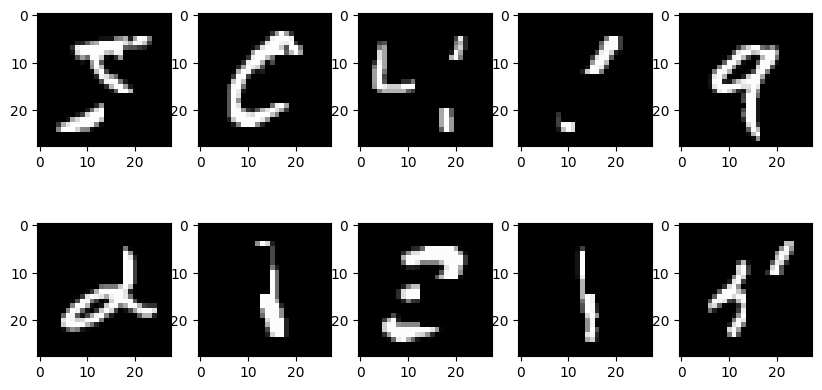

In [72]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the dataset (normalize to [0, 1])
x_train = (x_train.astype(np.float32) / 255.0).reshape(-1, 28, 28, 1)
x_test = (x_test.astype(np.float32) / 255.0).reshape(-1, 28, 28, 1)

# Add random occlusions to the dataset (simulate occlusion)
def add_occlusion(image, max_occlusion=10):
    x, y = np.random.randint(0, image.shape[0] - max_occlusion, 2)
    image[x:x+max_occlusion, y:y+max_occlusion] = 0
    return image

x_train_occluded = np.array([add_occlusion(image) for image in x_train])
x_test_occluded = np.array([add_occlusion(image) for image in x_test])

# Display some images with occlusion
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train_occluded[i].reshape(28, 28), cmap='gray')
plt.show()

In [68]:
y_train.shape

(60000,)

In [69]:
x_train.shape

(60000, 28, 28, 1)

In [53]:
y_test.shape

(10000,)

In [54]:
x_test.shape

(10000, 28, 28, 1)

In [55]:
x_train_occluded.shape

(60000, 28, 28, 1)

In [56]:
x_test_occluded.shape

(10000, 28, 28, 1)

# Build the Generative Model (GAN)
#### We will build a simple GAN that takes the occluded image as input and outputs a reconstructed image.

In [74]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, LeakyReLU, Input

# Generator
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_shape=(100,)))
    model.add(LeakyReLU(0.2))
    model.add(Dense(7 * 7 * 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', activation='sigmoid'))
    return model

# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compile GAN
def build_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)

    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    
    return gan

# Initialize models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)


# Train the GAN
#### We will train the GAN to reconstruct the occluded parts of the object (in this case, the MNIST digits).

In [58]:
def train_gan(generator, discriminator, gan, epochs=10000, batch_size=32):
    for epoch in range(epochs):
        # Get real images
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]
        
        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)
        
        # Labels
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        
        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        
        # Train the generator (via the combined model)
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))  # Trick the GAN
        g_loss = gan.train_on_batch(noise, valid_labels)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss_real}, G Loss: {g_loss}")

# Train GAN
train_gan(generator, discriminator, gan, epochs=500, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
Epoch 0, D Loss: [array(0.69667953, dtype=float32), array(0.5625, dtype=float32)], G Loss: [array(0.66839683, dtype=float32), array(0.66839683, dtype=float32), array(0.78125, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━

# Object Detection Model (YOLO or SSD)
#### For simplicity, we'll use a pre-trained object detection model (like YOLOv3 or SSD) from TensorFlow/Keras applications or a popular model zoo. The focus here is to improve object detection accuracy using the GAN-generated images.

In [75]:
from tensorflow.keras.applications import VGG16

# Use a pre-trained model for object detection (like SSD or YOLO)
object_detection_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for detection
model = Sequential([
    object_detection_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')  # Assuming 10 classes for MNIST detection
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model architecture
model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 21,140,042 (80.64 MB)

 Non-trainable params: 0 (0.00 B)

# 6. Training the Detection Model with Generated Images
### We can now train the object detection model on the occluded images and compare its performance with the images reconstructed by the GAN.

In [ ]:
from PIL import Image

#x_train = x_train.resize((32, 32))

[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0. 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0. 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0. 

In [64]:
# Train on occluded images
history = model.fit(x_train_occluded, x_train, epochs=10, batch_size=32)

# Now train with reconstructed images\

reconstructed_images = generator.predict(np.random.normal(0, 1, (x_train.shape[0], 100)))
history_reconstructed = model.fit(reconstructed_images, y_train, epochs=10, batch_size=32)


Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "vgg16" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(32, 28, 28)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 28, 28, 1), dtype=float32)
  • training=True
  • mask=None